In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import keras.utils as image
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

2024-03-25 23:44:23.333950: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 23:44:23.379470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 23:44:23.379509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 23:44:23.381015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 23:44:23.388687: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

In [3]:
image_size=(224,224,3)

In [4]:
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Check if it's a directory
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [6]:
train_images.shape

(7459, 224, 224, 3)

In [7]:
# Load ResNet50 with pre-trained weights on ImageNet
base_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_resnet50.output
x = GlobalAveragePooling2D()(x)

# Create the model
resnet50_with_gap = Model(inputs=base_resnet50.input, outputs=x)

2024-03-25 23:44:47.137438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 864 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-25 23:44:47.142069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7381 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-25 23:44:47.146107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 37953 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-25 23:44:47.148964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37953 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [8]:
# Function to extract features in batches
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [9]:
batch_size = 8
# Extract features using ResNet50
train_features = extract_features(resnet50_with_gap, train_images, batch_size)
test_features = extract_features(resnet50_with_gap, test_images, batch_size)


2024-03-25 23:44:49.818730: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-25 23:44:49.931396: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 2s 2s/step


2024-03-25 23:44:50.387264: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-25 23:44:50.432964: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 211ms/step


In [10]:
test_features[0]

array([-0.00000000e+00, -0.00000000e+00, -1.84410080e-01, -5.37802167e-02,
        3.55348539e+00, -7.87463337e-02, -0.00000000e+00, -1.89257443e-01,
       -1.62226588e-01, -0.00000000e+00, -2.32853040e-01, -1.87914409e-02,
       -1.11699775e-01, -2.32676044e-01, -0.00000000e+00, -0.00000000e+00,
       -7.91851431e-02, -1.62850499e-01, -1.33692110e-02, -0.00000000e+00,
       -4.92053702e-02, -1.71759307e-01, -1.65585250e-01,  1.06570780e-01,
       -0.00000000e+00, -1.51100472e-01, -0.00000000e+00, -2.15392798e-01,
       -1.51911210e-02,  4.16543245e-01, -5.79169914e-02, -5.89556340e-03,
       -0.00000000e+00, -6.62112832e-02, -5.97208478e-02, -6.26802072e-03,
       -0.00000000e+00, -2.59612113e-01, -8.22787508e-02,  2.44708881e-01,
       -2.78223962e-01, -0.00000000e+00, -0.00000000e+00, -1.94286201e-02,
       -1.11293122e-02, -3.01797509e-01, -9.56851840e-02, -1.55722573e-01,
       -1.38666667e-02, -2.81093586e-02, -0.00000000e+00, -0.00000000e+00,
        3.05425912e-01, -

In [11]:
# # Define the parameter grid
# param_grid = {'n_neighbors': [8], 'metric': ['minkowski']}
# Define the parameter grid for KNN
knn_param_grid = {'n_neighbors' : range(2,15),
               'metric' : ['minkowski','euclidean','manhattan']}

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Use GridSearchCV to find the best parameters for KNN
grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features, train_labels)

# Get the best parameters
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']


In [12]:
# Use the best parameters to train the final model
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric)
start_time = time.time()
final_knn_classifier.fit(train_features, train_labels)
train_time = time.time() - start_time

# Predict labels for the test set
knn_predictions = final_knn_classifier.predict(test_features)

# Evaluate accuracy
knn_accuracy = accuracy_score(test_labels, knn_predictions)
print("Best KNN Parameters:", grid_search.best_params_)
print("Best KNN Accuracy:", knn_accuracy)

# Additional evaluation metrics
precision = precision_score(test_labels, knn_predictions, average='weighted')
recall = recall_score(test_labels, knn_predictions, average='weighted')
f1 = f1_score(test_labels, knn_predictions, average='weighted')


print("Train Time (sec):", train_time)
# If you used GridSearchCV, you can access the training time with `cv_results_`
grid_train_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]
print("Train Time (sec) Grid:", grid_train_time)

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 3}
Best KNN Accuracy: 0.9843260188087775
Train Time (sec): 0.0049495697021484375
Train Time (sec) Grid: 0.027556737263997395


In [13]:
# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, knn_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Matthews Correlation Coefficient (MCC): 0.981735568085292


In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, knn_predictions)
precision = precision_score(test_labels, knn_predictions, average='weighted')

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# False omission rate
FOR_ = FN/(FN+TN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [15]:
# Compute True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR)

# Display results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("True Positive Rate (TPR):", np.mean(TPR))
print("True Negative Rate (TNR):", np.mean(TNR))
print("False Positive Rate (FPR):", np.mean(FPR))
print("False Negative Rate (FNR):", np.mean(FNR))
print("False Discovery Rate (FDR):", np.mean(FDR))
print("False Omission Rate (FOR):", np.mean(FOR_))
print("Overall accuracy (ACC):",np.mean(ACC))


Precision: 0.9843151654075051
Recall: 0.9843260188087775
F1 Score: 0.9842125651771962
True Positive Rate (TPR): 0.9614029304029305
True Negative Rate (TNR): 0.9993266346429914
False Positive Rate (FPR): 0.0006733653570087063
False Negative Rate (FNR): 0.0385970695970696
False Discovery Rate (FDR): 0.0346494087567913
False Omission Rate (FOR): 0.0006378757834577301
Overall accuracy (ACC): 0.9987460815047022


In [16]:
#Feature space (number of pixels in each image)
feature_space = train_images.shape
print("Feature Space:", feature_space)

# Accuracy for optimization algorithm (GridSearchCV)
optimization_accuracy = grid_search.best_score_
print("Optimization Algorithm Accuracy:", optimization_accuracy)


Feature Space: (7459, 224, 224, 3)
Optimization Algorithm Accuracy: 0.9757338320165908


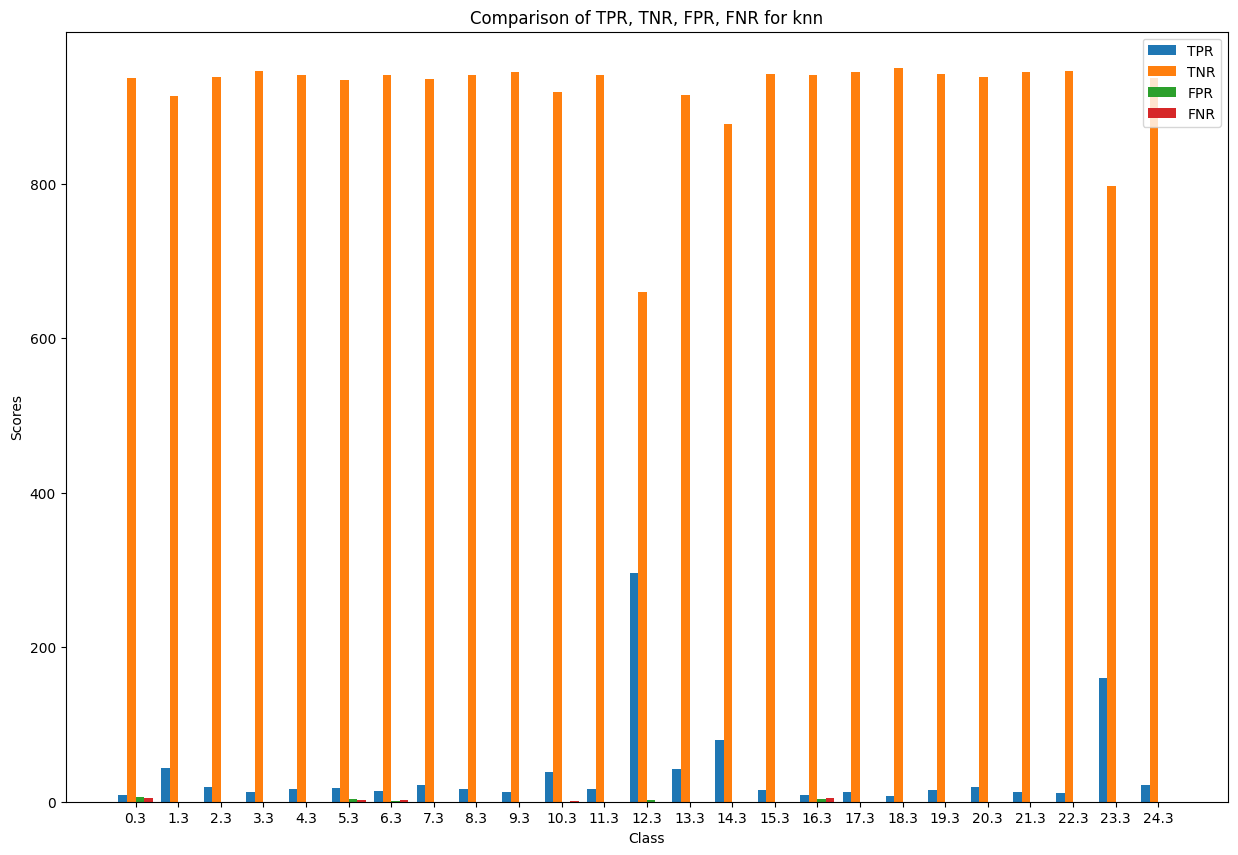

In [17]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

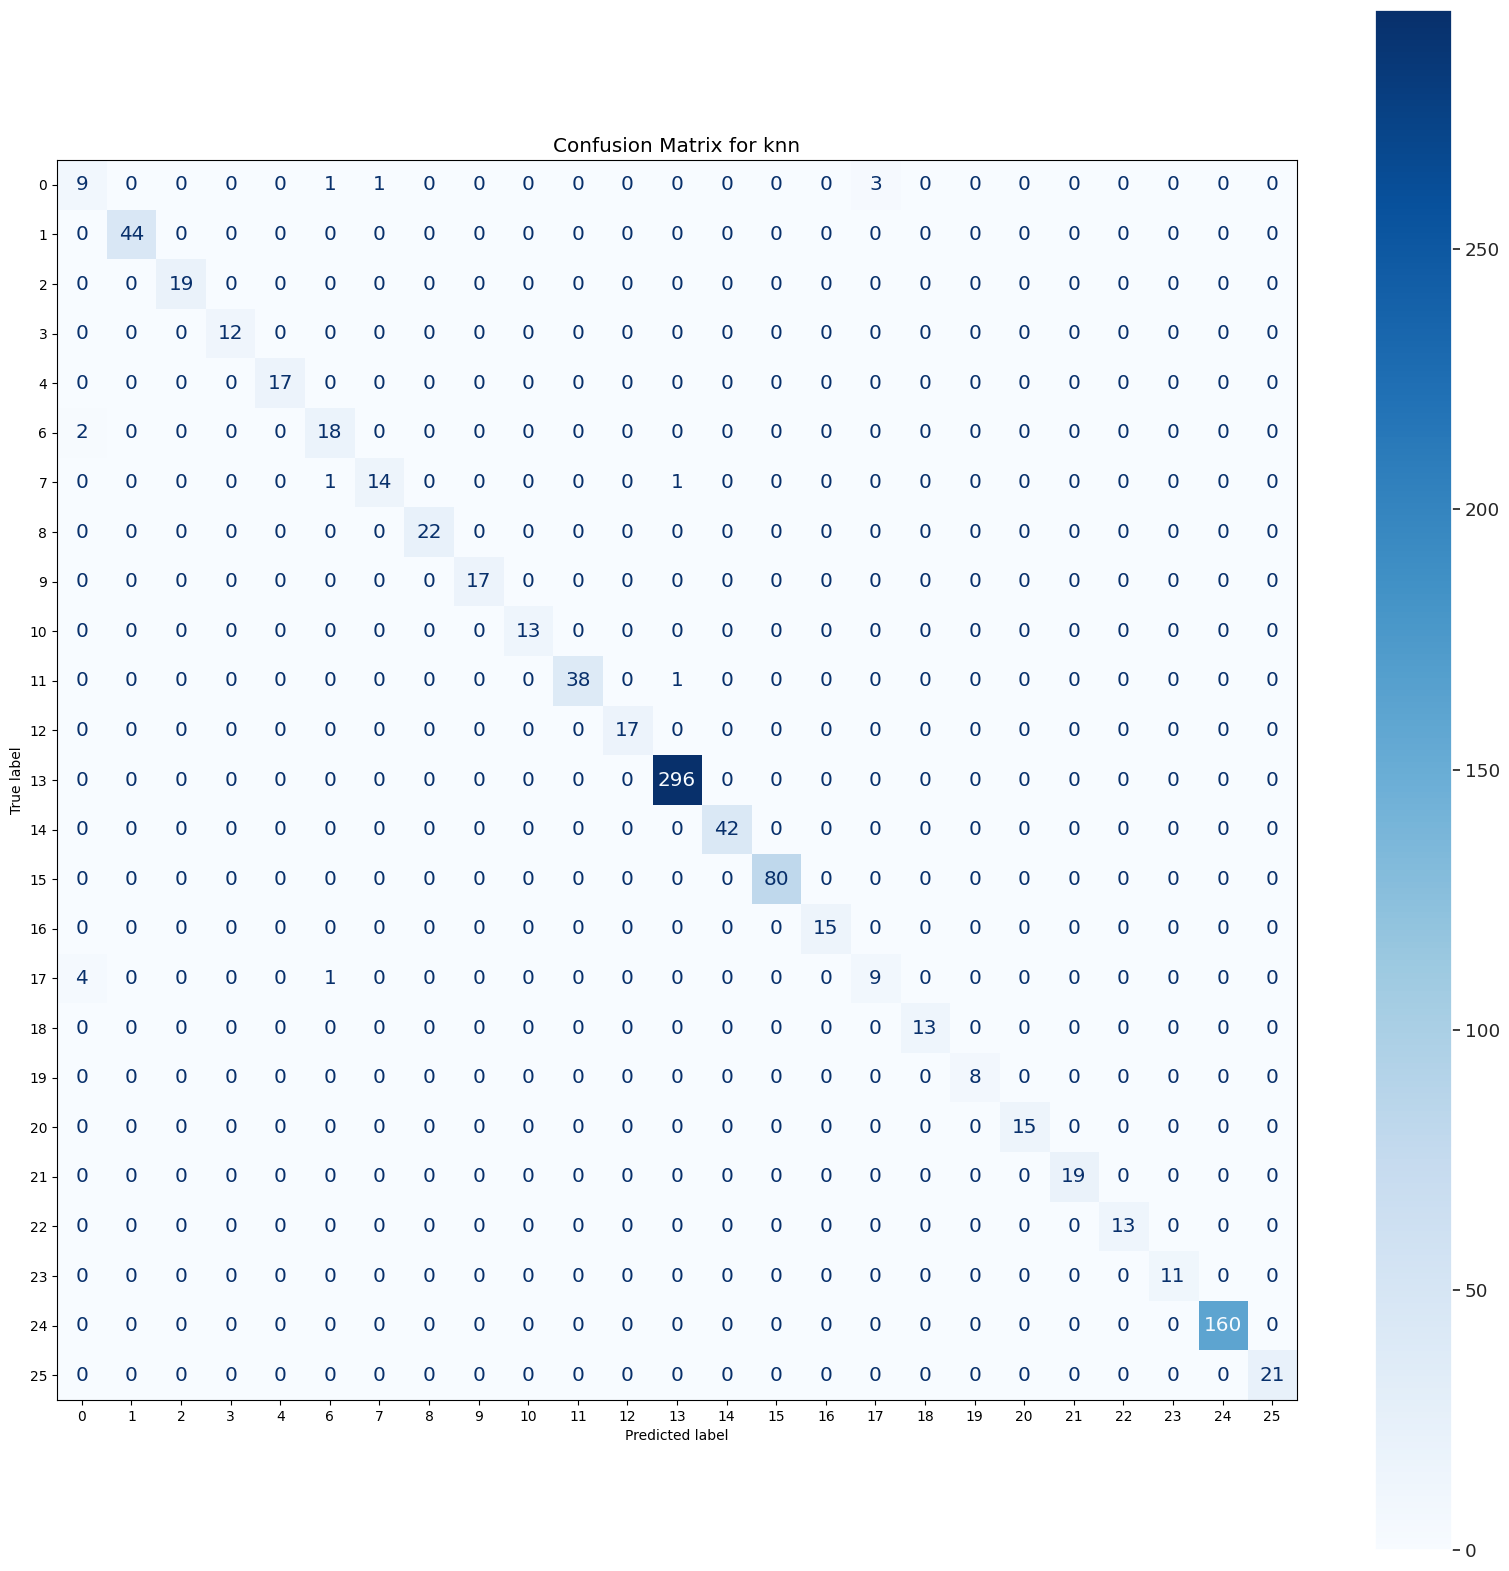

: 

In [18]:
# Plot Confusion Matrix for Naive Bayes
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for knn')
plt.show()